This notebook trains both cell line and patient DDPMs with domain alignment introduced between the latent spaces

In [1]:
import pandas as pd
import numpy as np

In [2]:
import torch
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader

In [3]:
import sys
sys.path.append("../src/tab_ddpm/")

In [4]:
from gaussian_multinomial_diffusion import GaussianMultinomialDiffusion
from modules import MLPDiffusion

In [5]:
sys.path.append("../src/")
from vae_model import vae
from loss_functions import get_kld_loss, coral, compute_covariance, ZINORMLoss
from ffnzinb_model import ffnzinb

In [6]:
device = torch.device("cuda:0")

### Load Datasets

#### Cell Lines

In [7]:
cl_train_df = pd.read_csv("../data/diffusion_pretraining/cl_diffusion_train_sample0.csv", index_col=0)
cl_train_df.shape

(1569, 7776)

In [8]:
cl_test_df = pd.read_csv("../data/diffusion_pretraining/cl_diffusion_test_sample0.csv", index_col=0)
cl_test_df.shape

(175, 7776)

In [9]:
cl_test_df

,ABL1_piu_max,ACVR1B_piu_max,AKT1_piu_max,AKT2_piu_max,AKT3_piu_max,ALK_piu_max,ALOX12B_piu_max,APC_piu_max,AR_piu_max,ARAF_piu_max,...,U2AF1_benign_count,VEGFA_benign_count,VHL_benign_count,WHSC1_benign_count,WHSC1L1_benign_count,WT1_benign_count,XPO1_benign_count,XRCC2_benign_count,ZNF217_benign_count,ZNF703_benign_count
DepMap_ID,,,,,,,,,,,,,,,,,,,,,
ACH-000031,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ACH-000257,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ACH-000418,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ACH-000594,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.235294,0.705882,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ACH-000783,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ACH-002163,0.000000,0.411765,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ACH-001616,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ACH-001532,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
cl_train_dataset = TensorDataset(torch.tensor(cl_train_df.values), torch.tensor(cl_train_df.values))
cl_test_dataset = TensorDataset(torch.tensor(cl_test_df.values), torch.tensor(cl_test_df.values))

In [11]:
cl_train_dataloader = DataLoader(cl_train_dataset, batch_size=128, shuffle=True)
cl_test_dataloader = DataLoader(cl_test_dataset, batch_size=128, shuffle=False)

#### Patient Dataset

In [12]:
tcga_train_df = pd.read_csv("../data/diffusion_pretraining/tcga_diffusion_train_sample0.csv", index_col=0)
tcga_train_df.shape

(476, 7776)

In [13]:
tcga_test_df = pd.read_csv("../data/diffusion_pretraining/tcga_diffusion_test_sample0.csv", index_col=0)
tcga_test_df.shape

(120, 7776)

In [14]:
tcga_train_dataset = TensorDataset(torch.tensor(tcga_train_df.values), torch.tensor(tcga_train_df.values))
tcga_test_dataset = TensorDataset(torch.tensor(tcga_test_df.values), torch.tensor(tcga_test_df.values))

In [15]:
tcga_train_dataloader = DataLoader(tcga_train_dataset, batch_size=128, shuffle=True)
tcga_test_dataloader = DataLoader(tcga_test_dataset, batch_size=128, shuffle=False)

#### Joint Training of Cell Line and Patient

Testing is still on patient data. Training involves iterating over cell lines and patients.

We use VAE + TTDPM in each case.

In [15]:
# testing function with LDM
def testing_loop_ldm(test_dataloader, diffusion_model, vae, device):
    avg_test_loss = 0.0
    for idx, batch in enumerate(test_dataloader):
        with torch.no_grad():
            inp_vae = batch[0].to(device=device, dtype=torch.float32)
            inp, mu, logvar, _ = vae(inp_vae) # From VAE encoder + reparameterization
            
            noise = torch.randn_like(inp).to(device) # this is the label we use   
            b = inp.shape[0]
            t, pt = diffusion_model.sample_time(b, device, 'uniform')
            inp_t = diffusion_model.gaussian_q_sample(inp, t, noise) # forward process
            model_out = diffusion_model._denoise_fn(inp_t, t) # predicted epsilon

            # MSE between predicted inp_pred after reverse diffusion and original input
            inp_pred = diffusion_model._predict_xstart_from_eps(inp_t, t, model_out)
            out_vae = vae.decoder(inp_pred) # after VAE decoding
            # X_mu1, X_theta1, X_pi1 = ffn_zinb_model(out_vae) # ZINorm
            mse_recon_loss = torch.nn.MSELoss()(out_vae, inp_vae) # MSE 

            avg_test_loss += mse_recon_loss.detach().item()

    return avg_test_loss/(idx+1)

In [16]:
# training function with LDM with CORAL loss
def training_loop_ldm_coral(train_dataloaders, test_dataloaders, epochs, diffusion_model, vae, device, optimizer):
    train_losses = []
    
    for i in range(epochs):
        loss = 0.0
        avg_test_loss = ""
        for idx0, batch0 in enumerate(train_dataloaders["cell_line"]):
            for idx1, batch1 in enumerate(train_dataloaders["patient"]):
                optimizer.zero_grad()
                # for cell lines
                inp_vae_cl = batch0[0].to(device=device, dtype=torch.float32)
                inp_cl, mu_cl, logvar_cl, _ = vae["cell_line"](inp_vae_cl) # From VAE encoder + reparameterization
                
                noise_cl = torch.randn_like(inp_cl).to(device) # this is the label we use   
                b = inp_cl.shape[0]
                t, pt = diffusion_model["cell_line"].sample_time(b, device, 'uniform')
                inp_t_cl = diffusion_model["cell_line"].gaussian_q_sample(inp_cl, t, noise_cl) # forward process
                model_out = diffusion_model["cell_line"]._denoise_fn(inp_t_cl, t) # predicted epsilon
                # loss calculation using MSE between predicted and actual noise
                loss_gauss_cl = diffusion_model["cell_line"]._gaussian_loss(model_out, inp_cl, inp_t_cl, t, noise_cl).mean()
    
                # reconstruct inp, pass through VAE decoder and calculate VAE losses
                inp_pred_cl = diffusion_model["cell_line"]._predict_xstart_from_eps(inp_t_cl, t, model_out)
                out_vae_cl = vae["cell_line"].decoder(inp_pred_cl) # after VAE decoding
                mse_recon_loss_cl = torch.nn.MSELoss()(out_vae_cl, inp_vae_cl)
                kld_loss_cl = get_kld_loss(mu_cl, logvar_cl, is_mean=True)

                # for patients
                inp_vae_tcga = batch1[0].to(device=device, dtype=torch.float32)
                inp_tcga, mu_tcga, logvar_tcga, _ = vae["patient"](inp_vae_tcga) # From VAE encoder + reparameterization
                
                noise_tcga = torch.randn_like(inp_tcga).to(device) # this is the label we use   
                b = inp_tcga.shape[0]
                t, pt = diffusion_model["patient"].sample_time(b, device, 'uniform')
                inp_t_tcga = diffusion_model["patient"].gaussian_q_sample(inp_tcga, t, noise_tcga) # forward process
                model_out = diffusion_model["patient"]._denoise_fn(inp_t_tcga, t) # predicted epsilon
                # loss calculation using MSE between predicted and actual noise
                loss_gauss_tcga = diffusion_model["patient"]._gaussian_loss(model_out, inp_tcga, inp_t_tcga, t, noise_tcga).mean()
    
                # reconstruct inp, pass through VAE decoder and calculate VAE losses
                inp_pred_tcga = diffusion_model["patient"]._predict_xstart_from_eps(inp_t_tcga, t, model_out)
                out_vae_tcga = vae["patient"].decoder(inp_pred_tcga) # after VAE decoding
                mse_recon_loss_tcga = torch.nn.MSELoss()(out_vae_tcga, inp_vae_tcga)
                kld_loss_tcga = get_kld_loss(mu_tcga, logvar_tcga, is_mean=True)
                
                # CORAL loss between latent spaces of VAEs - change to latnet space of diffusion models?
                coral_loss = coral(inp_cl, inp_tcga)
                
                total_loss = loss_gauss_cl + loss_gauss_tcga + mse_recon_loss_cl + mse_recon_loss_tcga + kld_loss_cl + kld_loss_tcga + coral_loss
                
                total_loss.backward()
                optimizer.step()
                # print(total_loss.detach().item())
                loss += total_loss.detach().item()

        if (i+1) % 10 == 0:
            avg_test_loss = f" Average testing loss: {testing_loop_ldm(test_dataloaders['patient'], diffusion_model['patient'], vae['patient'], device)}"

        print(f"|Epoch {i} | Average training loss: {loss/((idx0+1) * (idx1+1))} |{avg_test_loss}")
        train_losses.append(loss/((idx0+1) * (idx1+1)))
        
    return train_losses

In [17]:
train_dataloaders = {
    "cell_line": cl_train_dataloader,
    "patient": tcga_train_dataloader
}

In [18]:
test_dataloaders = {
    "cell_line": cl_test_dataloader,
    "patient": tcga_test_dataloader
}

In [19]:
device = torch.device("cuda:0")
vaes = {
    "cell_line": vae(input_dim=7776, k_list=[1024, 128], actf_list=["tanh", "tanh"], is_real=True).to(device),
    "patient": vae(input_dim=7776, k_list=[1024, 128], actf_list=["tanh", "tanh"], is_real=True).to(device)
}

U: encoder 
Sequential(
  (enc-0): Linear(in_features=7776, out_features=1024, bias=True)
  (act-0): Tanh()
  (enc-1): Linear(in_features=1024, out_features=128, bias=True)
  (act-1): Tanh()
)
#
mu_layer: 
Linear(in_features=128, out_features=64, bias=True)
#
sigma_layer: 
Linear(in_features=128, out_features=64, bias=True)
#
U: decoder 
Sequential(
  (-dec-0): Linear(in_features=64, out_features=128, bias=True)
  (-act-0): Tanh()
  (dec-0): Linear(in_features=128, out_features=1024, bias=True)
  (act-0): Tanh()
  (dec-1): Linear(in_features=1024, out_features=7776, bias=True)
  (act-1): Tanh()
)
U: encoder 
Sequential(
  (enc-0): Linear(in_features=7776, out_features=1024, bias=True)
  (act-0): Tanh()
  (enc-1): Linear(in_features=1024, out_features=128, bias=True)
  (act-1): Tanh()
)
#
mu_layer: 
Linear(in_features=128, out_features=64, bias=True)
#
sigma_layer: 
Linear(in_features=128, out_features=64, bias=True)
#
U: decoder 
Sequential(
  (-dec-0): Linear(in_features=64, out_featu

In [20]:
tcga_mlp_diffusion_model = MLPDiffusion(d_in=64, num_classes=0, is_y_cond=False, rtdl_params={"d_layers": [16], "dropout": 0.1})
tcga_diff_model = GaussianMultinomialDiffusion(num_classes=np.array([0]), num_numerical_features=64, denoise_fn=tcga_mlp_diffusion_model).to(device)

In [21]:
cl_mlp_diffusion_model = MLPDiffusion(d_in=64, num_classes=0, is_y_cond=False, rtdl_params={"d_layers": [16], "dropout": 0.1})
cl_diff_model = GaussianMultinomialDiffusion(num_classes=np.array([0]), num_numerical_features=64, denoise_fn=cl_mlp_diffusion_model).to(device)

In [22]:
diffusion_models = {
    "cell_line": cl_diff_model,
    "patient": tcga_diff_model
}

In [23]:
params = list(diffusion_models["cell_line"].parameters()) + list(diffusion_models["patient"].parameters()) + list(vaes["cell_line"].parameters()) + list(vaes["patient"].parameters())

In [24]:
optim = torch.optim.Adam(params, lr = 1e-6)

In [25]:
train_losses = training_loop_ldm_coral(train_dataloaders, test_dataloaders, 300, diffusion_models, vaes, device, optim)

/home/ajayago/miniconda3/envs/tddpm/lib/python3.9/site-packages/torch/_tensor.py:868: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


|Epoch 0 | Average training loss: 4.5867848350451546 |
|Epoch 1 | Average training loss: 4.451113471618066 |
|Epoch 2 | Average training loss: 4.455995302933913 |
|Epoch 3 | Average training loss: 4.304113209247589 |
|Epoch 4 | Average training loss: 4.324457223598774 |
|Epoch 5 | Average training loss: 4.315443763366113 |
|Epoch 6 | Average training loss: 4.256485696022327 |
|Epoch 7 | Average training loss: 4.2623430994840765 |
|Epoch 8 | Average training loss: 4.239712912302751 |
|Epoch 9 | Average training loss: 4.226761386944697 | Average testing loss: 15.556206703186035
|Epoch 10 | Average training loss: 4.2419651334102335 |
|Epoch 11 | Average training loss: 4.212326746720534 |
|Epoch 12 | Average training loss: 4.182461871550633 |
|Epoch 13 | Average training loss: 4.168912814213679 |
|Epoch 14 | Average training loss: 4.151487043270698 |
|Epoch 15 | Average training loss: 4.144377424166753 |
|Epoch 16 | Average training loss: 4.186107016526735 |
|Epoch 17 | Average training lo

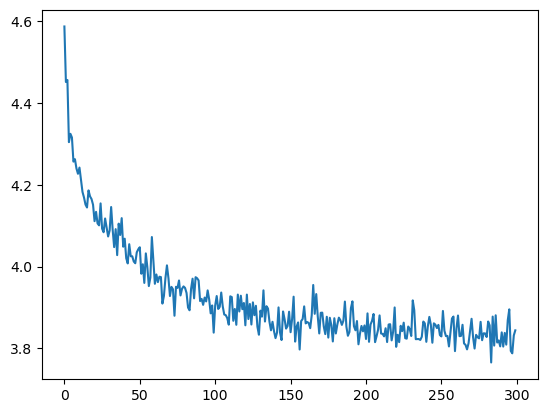

In [26]:
import matplotlib.pyplot as plt
plt.plot(train_losses)

In [27]:
torch.save(cl_diff_model.state_dict(), "/data/ajayago/druid/intermediate/cs6220/cl_diff_model_joint_UDA.pth")
torch.save(tcga_diff_model.state_dict(), "/data/ajayago/druid/intermediate/cs6220/tcga_diff_model_joint_UDA.pth")
torch.save(vaes["cell_line"].state_dict(), "/data/ajayago/druid/intermediate/cs6220/vae_cell_line_joint_UDA.pth")
torch.save(vaes["patient"].state_dict(), "/data/ajayago/druid/intermediate/cs6220/vae_patient_joint_UDA.pth")

#### Data Augmentation using Cell line data and patient DDPM

In [16]:
cl_vae = vae(input_dim=7776, k_list=[1024, 128], actf_list=["tanh", "tanh"], is_real=True)
tcga_vae = vae(input_dim=7776, k_list=[1024, 128], actf_list=["tanh", "tanh"], is_real=True)

U: encoder 
Sequential(
  (enc-0): Linear(in_features=7776, out_features=1024, bias=True)
  (act-0): Tanh()
  (enc-1): Linear(in_features=1024, out_features=128, bias=True)
  (act-1): Tanh()
)
#
mu_layer: 
Linear(in_features=128, out_features=64, bias=True)
#
sigma_layer: 
Linear(in_features=128, out_features=64, bias=True)
#
U: decoder 
Sequential(
  (-dec-0): Linear(in_features=64, out_features=128, bias=True)
  (-act-0): Tanh()
  (dec-0): Linear(in_features=128, out_features=1024, bias=True)
  (act-0): Tanh()
  (dec-1): Linear(in_features=1024, out_features=7776, bias=True)
  (act-1): Tanh()
)
U: encoder 
Sequential(
  (enc-0): Linear(in_features=7776, out_features=1024, bias=True)
  (act-0): Tanh()
  (enc-1): Linear(in_features=1024, out_features=128, bias=True)
  (act-1): Tanh()
)
#
mu_layer: 
Linear(in_features=128, out_features=64, bias=True)
#
sigma_layer: 
Linear(in_features=128, out_features=64, bias=True)
#
U: decoder 
Sequential(
  (-dec-0): Linear(in_features=64, out_featu

In [17]:
cl_vae.load_state_dict(torch.load("/data/ajayago/druid/intermediate/cs6220/vae_cell_line_joint_UDA.pth"))

<All keys matched successfully>

In [18]:
tcga_vae.load_state_dict(torch.load("/data/ajayago/druid/intermediate/cs6220/vae_patient_joint_UDA.pth"))

<All keys matched successfully>

In [19]:
cl_mlp_diffusion_model = MLPDiffusion(d_in=64, num_classes=0, is_y_cond=False, rtdl_params={"d_layers": [16], "dropout": 0.1})
cl_diff_model = GaussianMultinomialDiffusion(num_classes=np.array([0]), num_numerical_features=64, denoise_fn=cl_mlp_diffusion_model)
cl_diff_model.load_state_dict(torch.load("/data/ajayago/druid/intermediate/cs6220/cl_diff_model_joint_UDA.pth"))

<All keys matched successfully>

In [20]:
tcga_mlp_diffusion_model = MLPDiffusion(d_in=64, num_classes=0, is_y_cond=False, rtdl_params={"d_layers": [16], "dropout": 0.1})
tcga_diff_model = GaussianMultinomialDiffusion(num_classes=np.array([0]), num_numerical_features=64, denoise_fn=tcga_mlp_diffusion_model)
tcga_diff_model.load_state_dict(torch.load("/data/ajayago/druid/intermediate/cs6220/tcga_diff_model_joint_UDA.pth"))

<All keys matched successfully>

In [21]:
# inference
cl_diff_model.eval()
tcga_diff_model.eval()
cl_vae.eval()
tcga_vae.eval()
cl_mlp_diffusion_model.eval()
tcga_mlp_diffusion_model.eval()

MLPDiffusion(
  (mlp): MLP(
    (blocks): ModuleList(
      (0): Block(
        (linear): Linear(in_features=128, out_features=16, bias=True)
        (activation): ReLU()
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (head): Linear(in_features=16, out_features=64, bias=True)
  )
  (proj): Linear(in_features=64, out_features=128, bias=True)
  (time_embed): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): SiLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
  )
)

In [33]:
def augmented_cl(dataloader):
    augmented = []
    for idx, batch in enumerate(dataloader):
        inp_vae = batch[0].to(dtype=torch.float32)
        inp, mu, logvar, _ = cl_vae(inp_vae) # From VAE encoder + reparameterization
        
        noise = torch.randn_like(inp) # this is the label we use   
        b = inp.shape[0]
        # t, pt = diffusion_model["cell_line"].sample_time(b, device, 'uniform')
        t = (torch.ones((b,)) * 700).long() # fixing time steps to 500
        pt = torch.ones_like(t).float() / cl_diff_model.num_timesteps
        inp_t = cl_diff_model.gaussian_q_sample(inp, t, noise) # forward process with cell line model encoder
        model_out = tcga_diff_model._denoise_fn(inp_t, t) # predicted epsilon from patient decoder
    
        # predict inp from noise using patient model
        inp_pred = tcga_diff_model._predict_xstart_from_eps(inp_t, t, model_out)
        out_vae = tcga_vae.decoder(inp_pred) # after VAE decoding with patient decoder
        augmented.append(out_vae)
    return torch.cat(augmented, axis = 0)

In [34]:
augmented_cl_data_test = augmented_cl(cl_test_dataloader)

In [35]:
augmented_cl_data_test.shape

torch.Size([175, 7776])

In [36]:
augmented_cl_data_train = augmented_cl(cl_train_dataloader)

In [37]:
augmented_cl_data_train.shape

torch.Size([1569, 7776])

#### Plotting TSNE for the augmented cell line data and actual patient data

In [39]:
from sklearn.manifold import TSNE

In [40]:
tsne = TSNE()

In [44]:
tcga_tsne = tsne.fit_transform(pd.concat([tcga_train_df, tcga_test_df]).values)

In [45]:
tcga_tsne.shape

(596, 2)

In [47]:
augmented_cell_line = torch.cat((augmented_cl_data_train, augmented_cl_data_test), axis = 0).detach().numpy()
augmented_cell_line.shape

(1744, 7776)

In [48]:
augmented_cell_line_tsne = tsne.fit_transform(augmented_cell_line)

In [49]:
augmented_cell_line_tsne.shape

(1744, 2)

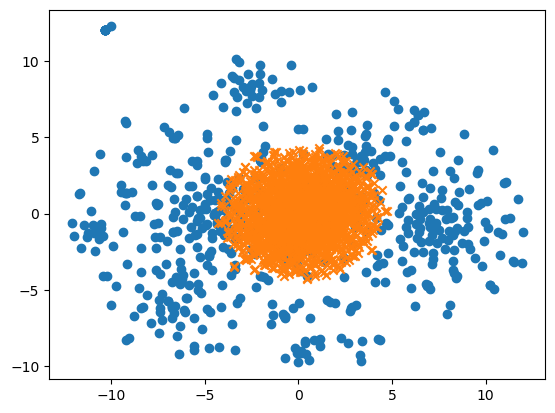

In [56]:
plt.scatter(tcga_tsne[:,0], tcga_tsne[:, 1])
plt.scatter(augmented_cell_line_tsne[:,0], augmented_cell_line_tsne[:, 1], marker="x")

In [58]:
# on original cell line data
augmented_cell_line_tsne_orig = tsne.fit_transform(pd.concat([cl_train_df, cl_test_df]).values)
augmented_cell_line_tsne_orig.shape

(1744, 2)

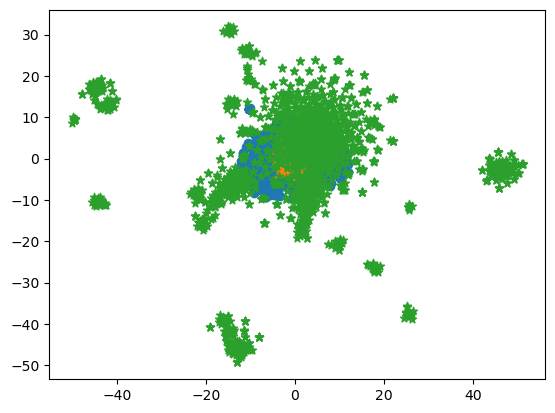

In [59]:
plt.scatter(tcga_tsne[:,0], tcga_tsne[:, 1])
plt.scatter(augmented_cell_line_tsne[:,0], augmented_cell_line_tsne[:, 1], marker="x")
plt.scatter(augmented_cell_line_tsne_orig[:,0], augmented_cell_line_tsne_orig[:, 1], marker="*")

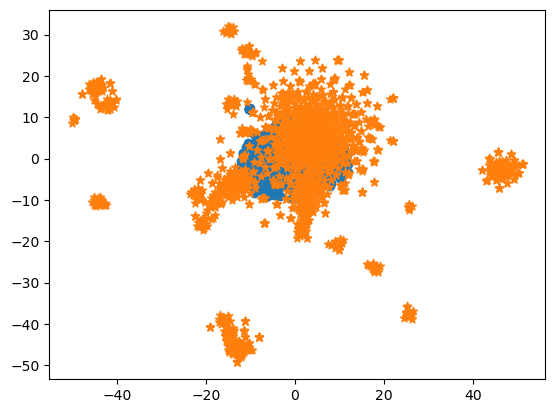

In [60]:
# dist shift between cell lines and tcga before transforms
plt.scatter(tcga_tsne[:,0], tcga_tsne[:, 1])
plt.scatter(augmented_cell_line_tsne_orig[:,0], augmented_cell_line_tsne_orig[:, 1], marker="*")

In [65]:
augmented_cl_df = pd.DataFrame(augmented_cell_line, columns = cl_train_df.columns, index=list(cl_train_df.index) + list(cl_test_df.index))
print(augmented_cl_df.shape)
augmented_cl_df.to_csv("/data/ajayago/druid/intermediate/cs6220/augmented_cl_joint_UDA.csv")

(1744, 7776)


In [66]:
augmented_cl_df

,ABL1_piu_max,ACVR1B_piu_max,AKT1_piu_max,AKT2_piu_max,AKT3_piu_max,ALK_piu_max,ALOX12B_piu_max,APC_piu_max,AR_piu_max,ARAF_piu_max,...,U2AF1_benign_count,VEGFA_benign_count,VHL_benign_count,WHSC1_benign_count,WHSC1L1_benign_count,WT1_benign_count,XPO1_benign_count,XRCC2_benign_count,ZNF217_benign_count,ZNF703_benign_count
ACH-002277,0.004723,-0.074524,-0.064620,-0.051929,-0.028703,0.024461,0.002217,0.002974,0.009592,-0.008397,...,-0.000427,0.052330,0.011620,0.004458,-0.024069,-0.010735,0.010126,-0.037632,-0.032282,0.025392
ACH-000046,-0.044151,0.013211,-0.007219,0.061254,0.019710,0.037984,0.074833,0.025340,-0.023879,0.020951,...,0.063373,-0.006409,0.014718,0.008724,0.041279,-0.011608,-0.017573,-0.000683,-0.006830,-0.012897
ACH-000674,-0.031876,-0.035646,-0.005145,0.028493,0.015599,-0.004415,0.012403,-0.009433,0.069723,-0.014906,...,-0.025623,-0.030465,0.025656,0.065800,0.028408,0.029893,0.032494,0.004267,-0.003192,-0.028522
ACH-000557,0.037555,-0.051878,0.002764,-0.033034,0.000317,0.016432,0.010172,-0.001846,-0.030163,-0.012192,...,-0.005714,-0.049075,-0.021316,0.023776,0.043987,-0.020036,0.054721,-0.013249,-0.017701,0.005902
ACH-001642,0.002462,0.022005,0.034970,0.022071,0.000026,-0.003967,0.043710,-0.042727,-0.020800,0.011919,...,-0.048954,-0.024483,-0.046746,-0.007807,0.038422,0.003833,-0.034289,-0.003381,-0.006845,0.004189
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ACH-002163,0.019159,-0.034390,-0.042690,-0.004542,0.041448,0.052593,0.028654,-0.015578,-0.007461,0.012553,...,-0.001547,-0.025656,0.045009,-0.024141,0.023231,-0.050883,0.009611,-0.011065,-0.017703,0.003498
ACH-001616,-0.009271,0.050954,0.011915,0.032517,-0.012457,-0.037581,-0.009486,-0.013465,-0.061523,0.003963,...,-0.020319,0.049187,0.004197,0.010419,0.009221,0.039876,-0.040284,-0.039533,0.027733,0.031373
ACH-001532,-0.049339,-0.039037,0.012419,-0.020343,0.014652,0.019977,-0.007930,0.026415,0.028470,0.001728,...,0.011819,0.054863,0.069070,0.015084,0.051132,0.012693,-0.048643,0.003243,-0.018845,0.047419
ACH-000993,-0.011444,0.057573,-0.013688,-0.027055,-0.041923,0.000788,0.057440,0.023220,-0.002711,0.013793,...,-0.044856,0.023337,0.022597,-0.016103,-0.041479,0.049218,-0.034121,0.015316,-0.030126,-0.000028
